In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Analysis of machine_meta csv - 

In [2]:
machine_meta = pd.read_csv('data/machine_meta.csv', header=None,
                           names=['machine_id','time_stamp','failure_domain_1',
                                  'failure_domain_2','cpu_num','mem_size','status'])
machine_meta.head()

,machine_id,time_stamp,failure_domain_1,failure_domain_2,cpu_num,mem_size,status
0,m_1,0,219,17.0,96,100,USING
1,m_1,148984,219,17.0,96,100,USING
2,m_1,535156,219,17.0,96,100,USING
3,m_1,552384,219,17.0,96,100,USING
4,m_1,658423,219,17.0,96,100,USING


# Analysis of machine_usage csv - 

In [4]:
# Reading 50 Million rows
machine_usage = pd.read_csv('data/machine_usage.csv', header=None, nrows=50000000, 
                            names=['machine_id','time_stamp','cpu_util_percent',
                                   'mem_util_percent','mem_gps','mkpi','net_in',
                                   'net_out','disk_io_percent'])

machine_usage = machine_usage.sort_values(by='time_stamp')
machine_usage

,machine_id,time_stamp,cpu_util_percent,mem_util_percent,mem_gps,mkpi,net_in,net_out,disk_io_percent
44625343,m_425,0,47,89,NaN,NaN,34.90,28.60,3
18549314,m_626,0,20,90,NaN,NaN,37.23,32.58,5
7872991,m_3089,0,7,88,NaN,NaN,29.93,20.88,1
42495312,m_111,0,18,92,NaN,NaN,39.17,32.09,3
47147418,m_796,0,24,75,NaN,NaN,41.86,37.79,5
...,...,...,...,...,...,...,...,...,...
5118577,m_2682,691190,24,96,3.22,0.0,52.53,39.73,3
22689894,m_1234,691190,34,93,3.83,0.0,54.69,47.62,5
49827147,m_1189,691190,32,94,4.53,0.0,49.68,39.85,5
48406478,m_979,691190,85,90,0.41,0.0,53.88,51.05,3


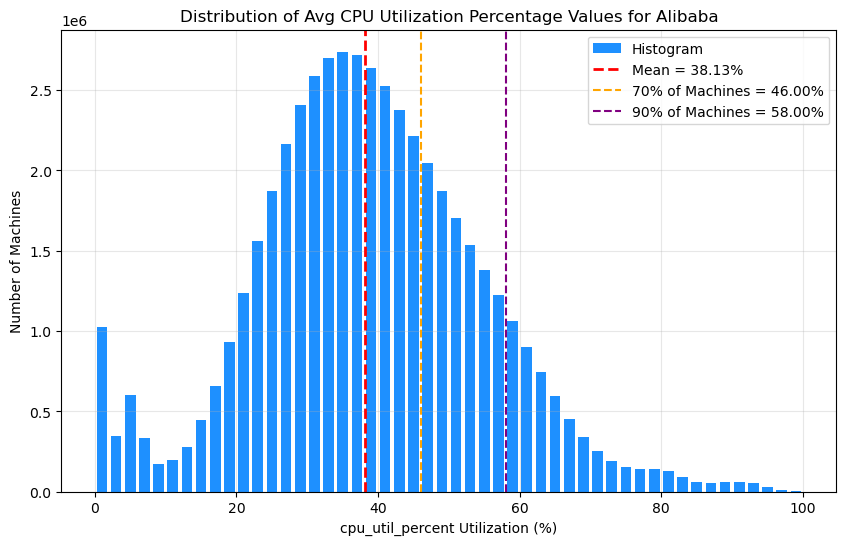

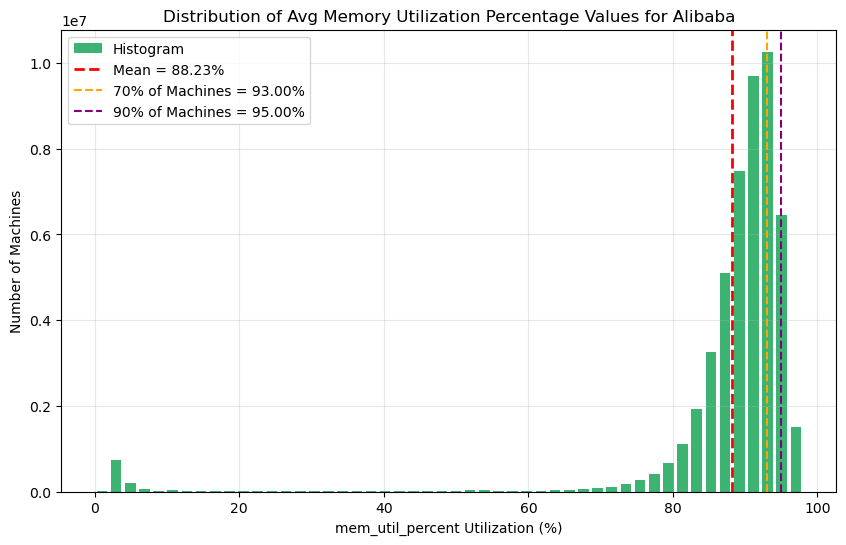

In [5]:
def plot_resource_analysis(dataframe, col_name, xlabel, title):
    plt.figure(figsize=(10, 6))
    data = dataframe[col_name].dropna()
    mean_val = data.mean()
    p70 = np.percentile(data, 70)
    p90 = np.percentile(data, 90)

    color = "dodgerblue" if col_name.startswith('cpu') else "mediumseagreen"
    plt.hist(data, bins=50, rwidth=0.75, color=color, label='Histogram')
    plt.title(title)
    plt.xlabel(f"{xlabel} Utilization (%)")
    plt.ylabel("Number of Machines")
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}%')
    plt.axvline(p70, color='orange', linestyle='--', linewidth=1.5, label=f'70% of Machines = {p70:.2f}%')
    plt.axvline(p90, color='purple', linestyle='--', linewidth=1.5, label=f'90% of Machines = {p90:.2f}%')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(f'alibaba_{col_name}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_resource_analysis(machine_usage, 'cpu_util_percent', "cpu_util_percent", "Distribution of Avg CPU Utilization Percentage Values for Alibaba")
plot_resource_analysis(machine_usage, 'mem_util_percent', "mem_util_percent", "Distribution of Avg Memory Utilization Percentage Values for Alibaba")

## Hourly CPU & MEM Utilization Patterns - 

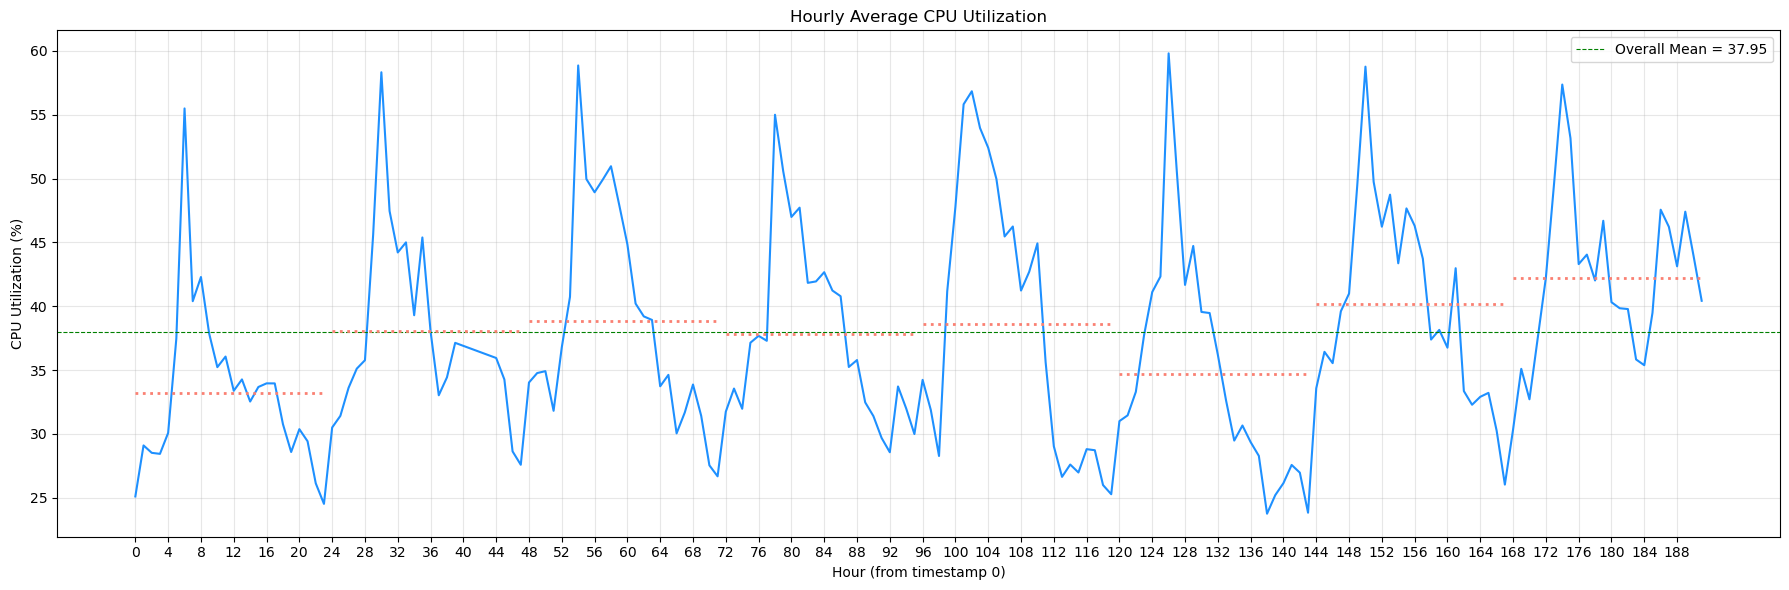

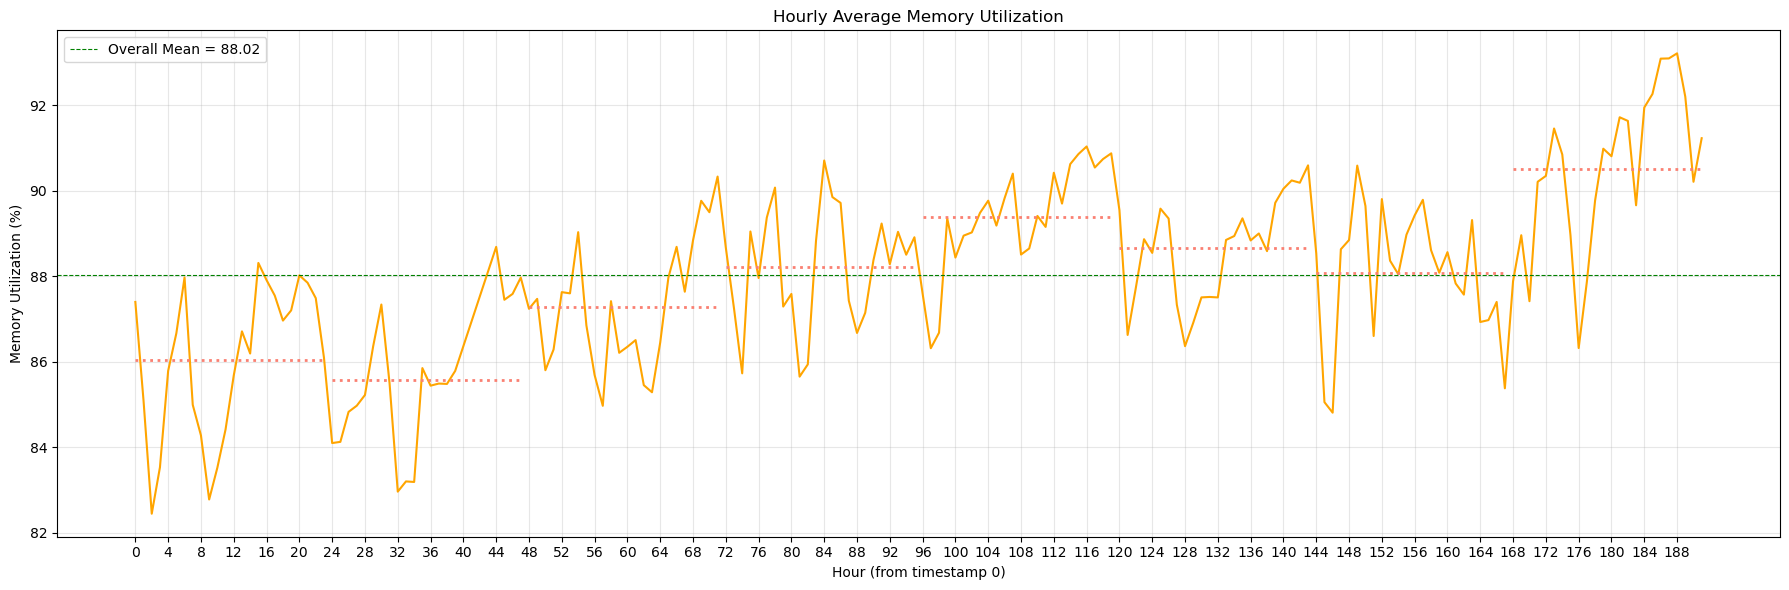

In [6]:
# Splitting data into hours
machine_usage['hour'] = machine_usage['time_stamp'] // 3600
# Calculating hourly averages
hourly_avg = machine_usage.groupby('hour')[['cpu_util_percent', 'mem_util_percent']].mean().reset_index()

def plot_with_24h_means(data, col_name, color, ylabel, title):
    plt.figure(figsize=(18, 6))
    plt.plot(data['hour'], data[col_name], color=color, linewidth=1.5)
    overall_mean = data[col_name].mean()
    plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth=0.8, label=f'Overall Mean = {overall_mean:.2f}')
    
    max_hour = data['hour'].max()
    for start in range(0, max_hour + 1, 24):
        end = start + 24
        block = data[(data['hour'] >= start) & (data['hour'] < end)]
        if not block.empty:
            block_mean = block[col_name].mean()
            plt.hlines(y=block_mean, xmin=start, xmax=min(end - 1, max_hour), colors='salmon', linestyles='dotted', linewidth=2)

    plt.title(title)
    plt.xlabel('Hour (from timestamp 0)')
    plt.ylabel(ylabel)
    plt.xticks(ticks=np.arange(0, max_hour + 1, 4))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'alibaba_plots/Alibaba_{col_name}_plot')
    plt.show()

# Plotting CPU Utilization
plot_with_24h_means(data=hourly_avg, col_name='cpu_util_percent', color='dodgerblue', ylabel='CPU Utilization (%)', title='Hourly Average CPU Utilization')

# Plotting Memory Utilization
plot_with_24h_means(data=hourly_avg, col_name='mem_util_percent', color='orange', ylabel='Memory Utilization (%)', title='Hourly Average Memory Utilization')

## Machine Utilization Patterns -

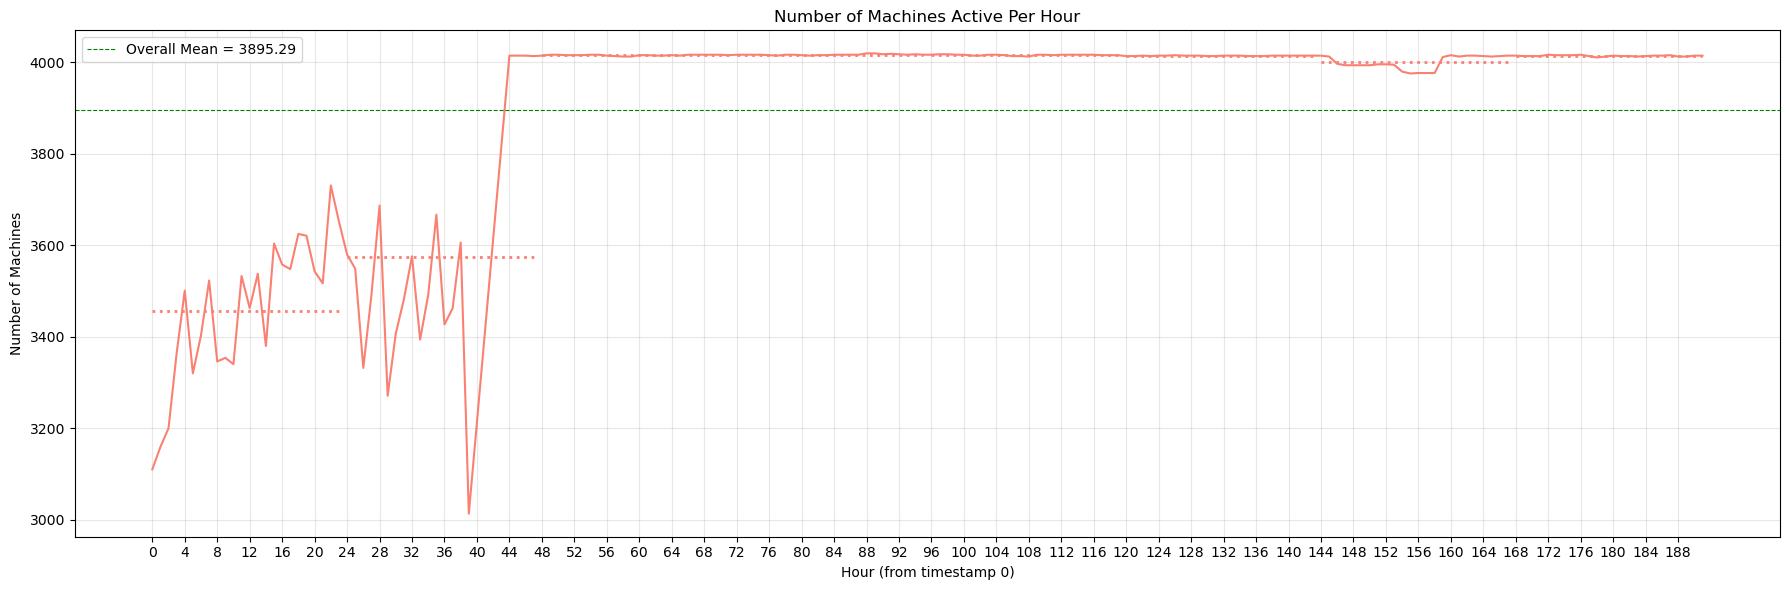

In [7]:
machines_per_hour = (machine_usage.groupby('hour')['machine_id'].nunique().reset_index(name='num_unique_machines'))
plot_with_24h_means(data=machines_per_hour, col_name='num_unique_machines', color='salmon', ylabel='Number of Machines', title='Number of Machines Active Per Hour')

## Incoming & Outgoing Traffic Patterns - 

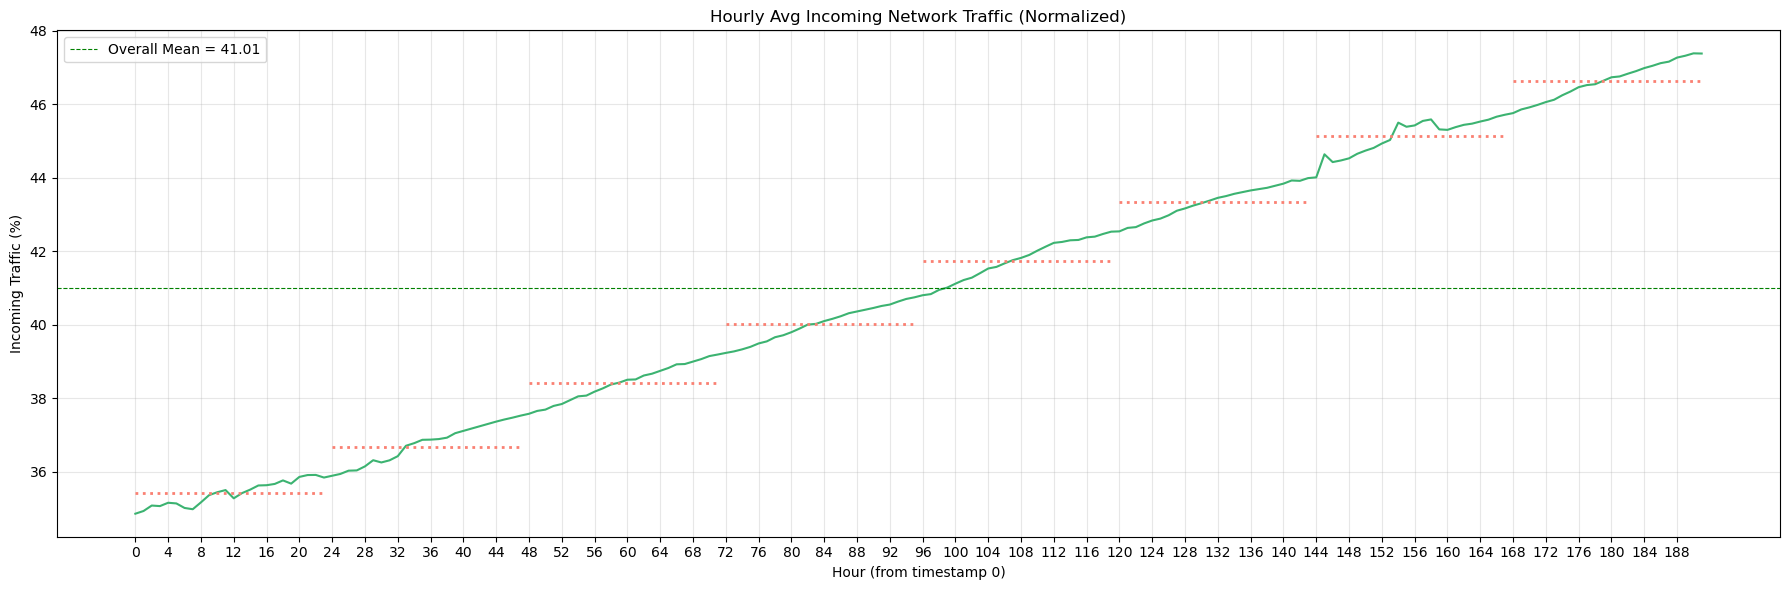

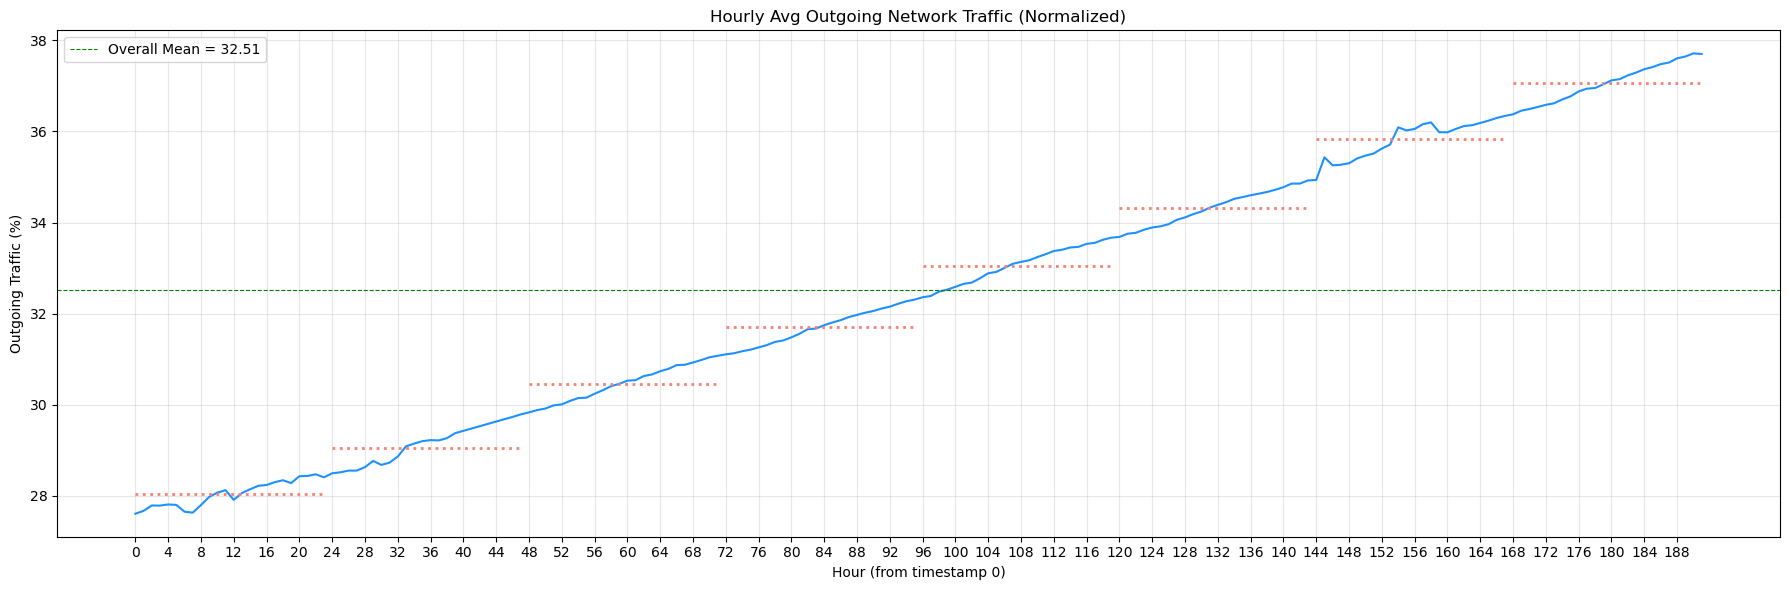

In [8]:
hourly_net = machine_usage.groupby('hour')[['net_in', 'net_out']].mean().reset_index()
plot_with_24h_means(data=hourly_net, col_name='net_in', color='mediumseagreen', ylabel='Incoming Traffic (%)', title='Hourly Avg Incoming Network Traffic (Normalized)')
plot_with_24h_means(data=hourly_net, col_name='net_out', color='dodgerblue', ylabel='Outgoing Traffic (%)', title='Hourly Avg Outgoing Network Traffic (Normalized)')

## Disk I/O Percent Patterns - 

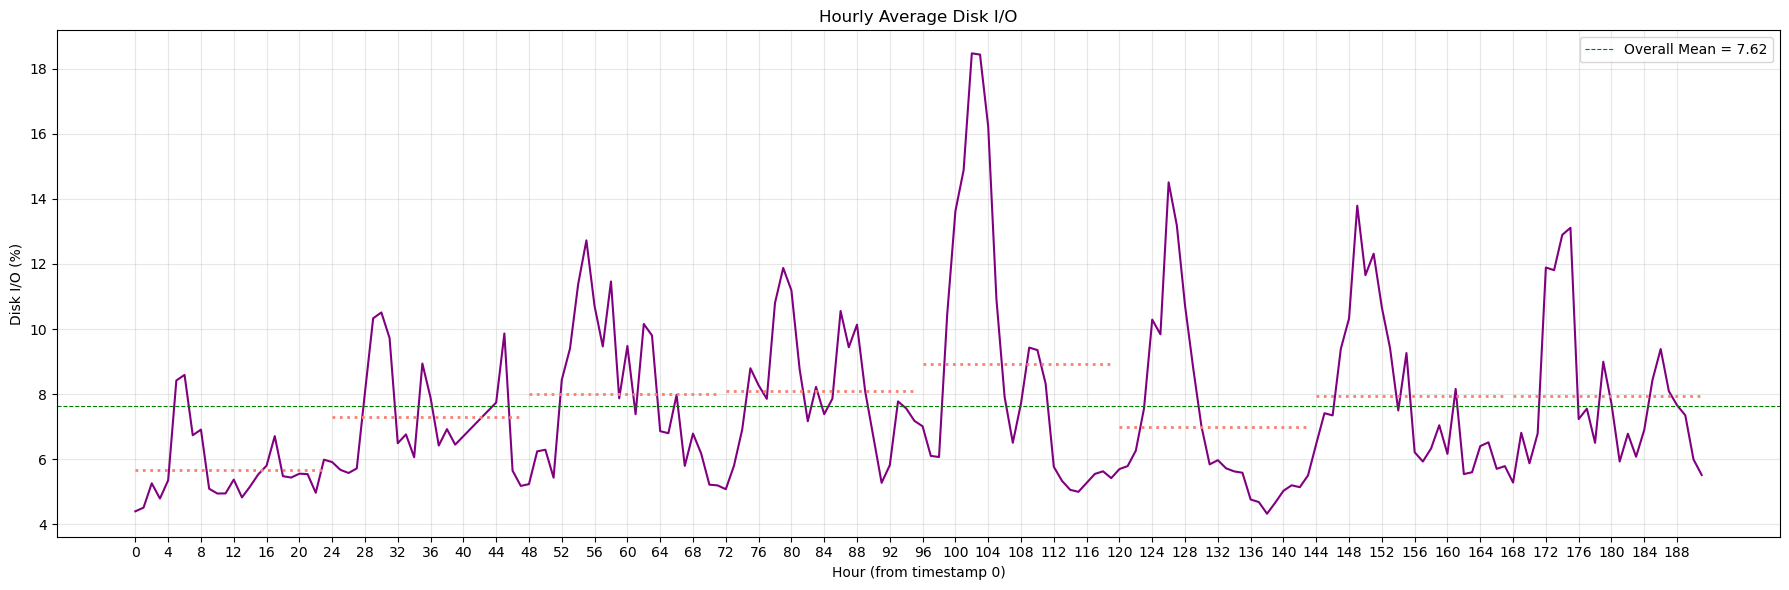

In [9]:
hourly_disk_io = machine_usage[(machine_usage['disk_io_percent'] >= 0) & (machine_usage['disk_io_percent'] <= 100)]
hourly_disk_io = hourly_disk_io.groupby('hour')[['disk_io_percent']].mean().reset_index()

plot_with_24h_means(data=hourly_disk_io, col_name='disk_io_percent', color='purple', ylabel='Disk I/O (%)', title='Hourly Average Disk I/O')

# Analysis of container_meta csv - 

In [10]:
container_meta = pd.read_csv('data/container_meta.csv', header=None, 
                              names=['container_id','machine_id', 'time_stamp','cpu_util_percent',
                                     'mem_util_percent','cpi','mem_gps','mpki','net_in','net_out',
                                     'disk_io_percent'])
container_meta.head()

,container_id,machine_id,time_stamp,cpu_util_percent,mem_util_percent,cpi,mem_gps,mpki,net_in,net_out,disk_io_percent
0,c_1,m_2556,0,app_5052,started,400,400,1.56,NaN,NaN,NaN
1,c_1,m_2556,287942,app_5052,started,400,400,1.56,NaN,NaN,NaN
2,c_1,m_2556,338909,app_5052,started,400,400,1.56,NaN,NaN,NaN
3,c_2,m_962,0,app_8125,started,800,800,3.13,NaN,NaN,NaN
4,c_2,m_962,23205,app_8125,started,800,800,3.13,NaN,NaN,NaN


# Analysis of batch_task csv - 

In [11]:
# Reading 50 million rows
batch_task = pd.read_csv('data/batch_task.csv', header=None, nrows=50000000,
                         names=['task_name','instance_num','job_name','task_type',
                                'status','start_time_task','end_time_task','plan_cpu','plan_mem'])
batch_task = batch_task[batch_task['status'] == 'Running']
batch_task.head()

,task_name,instance_num,job_name,task_type,status,start_time_task,end_time_task,plan_cpu,plan_mem
102,task_MTM0ODUxMTY0NjQzMTI1NTc1MQ==,1.0,j_85,6,Running,474800,0,NaN,NaN
103,task_LTE4NjUxMjg5NDY5MDI4NjAzNzU=,1.0,j_85,6,Running,474800,0,NaN,NaN
277,task_LTE4NjUxMjg5NDY5MDI4NjAzNzU=,1.0,j_189,6,Running,617172,0,NaN,NaN
742,task_LTE4NjUxMjg5NDY5MDI4NjAzNzU=,1.0,j_655,6,Running,487939,0,NaN,NaN
743,task_MTM0ODUxMTY0NjQzMTI1NTc1MQ==,1.0,j_655,6,Running,487939,0,NaN,NaN


In [12]:
running_tasks = batch_task[batch_task['status'] == 'Running']
running_tasks = running_tasks.sort_values(by=['start_time_task', 'end_time_task'])
running_tasks = running_tasks.dropna(subset=['plan_cpu', 'plan_mem'])
# Splitting data into hours
running_tasks['start_hour'] = running_tasks['start_time_task'] // 3600
running_tasks['end_hour'] = running_tasks['end_time_task'] // 3600
running_tasks = running_tasks[['task_name', 'task_type', 'plan_cpu', 'plan_mem','start_hour', 'end_hour']]
running_tasks

,task_name,task_type,plan_cpu,plan_mem,start_hour,end_hour
771712,J5_2_3_4,1,100.0,0.59,0,0
9948906,J5_4,1,50.0,0.59,0,0
10078188,task_NDg2ODM2NDIyMDczNDQ4NzMzOA==,11,700.0,0.40,0,0
10078189,task_NzkwNTc4MjA2ODI2MzE3NzU4MQ==,11,300.0,0.19,0,0
1739122,J13_2_3_4_12,1,100.0,0.49,0,0
...,...,...,...,...,...,...
7950645,J11_6_10,1,50.0,0.39,191,192
7950647,J9_3_4_8,1,50.0,0.39,191,192
7950648,J10_2_9,1,50.0,0.30,191,192
7950651,J14_1_13,1,50.0,0.30,191,192


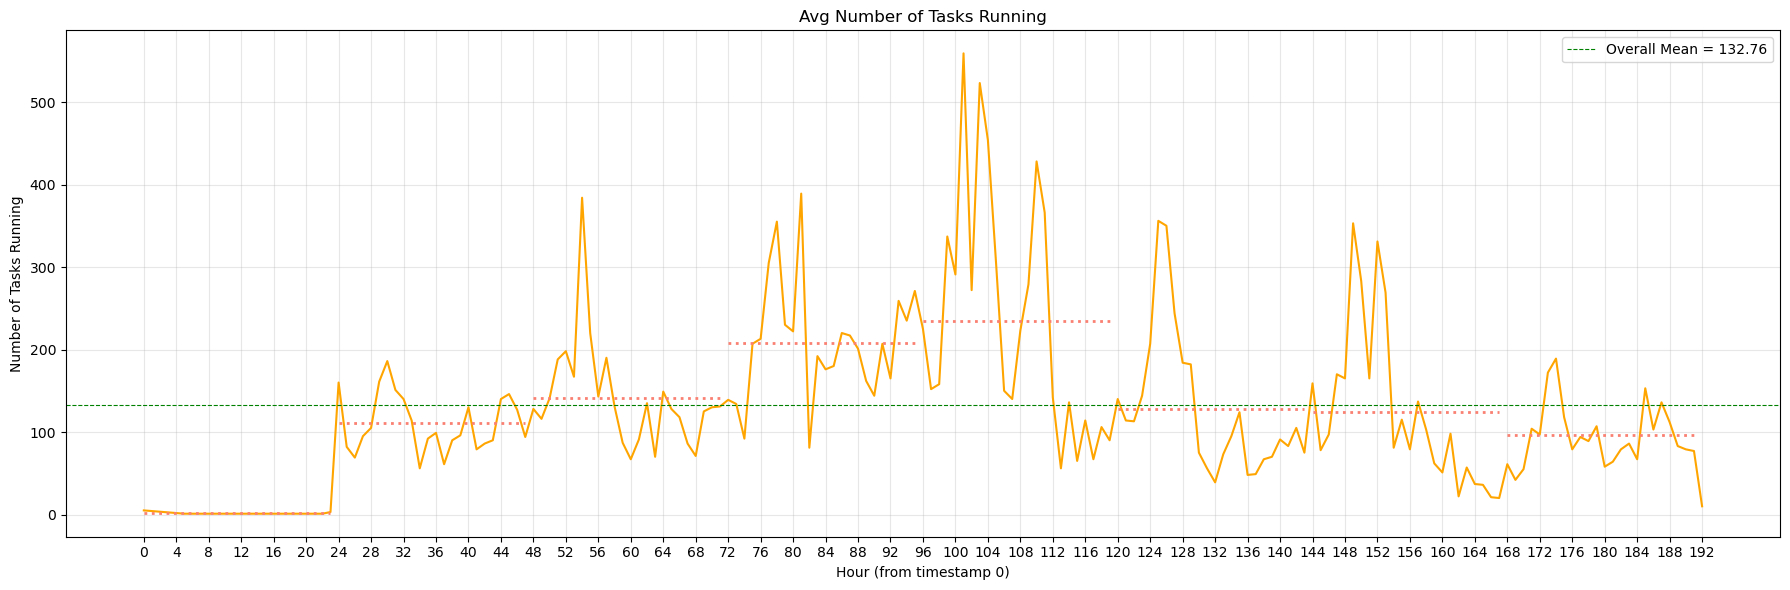

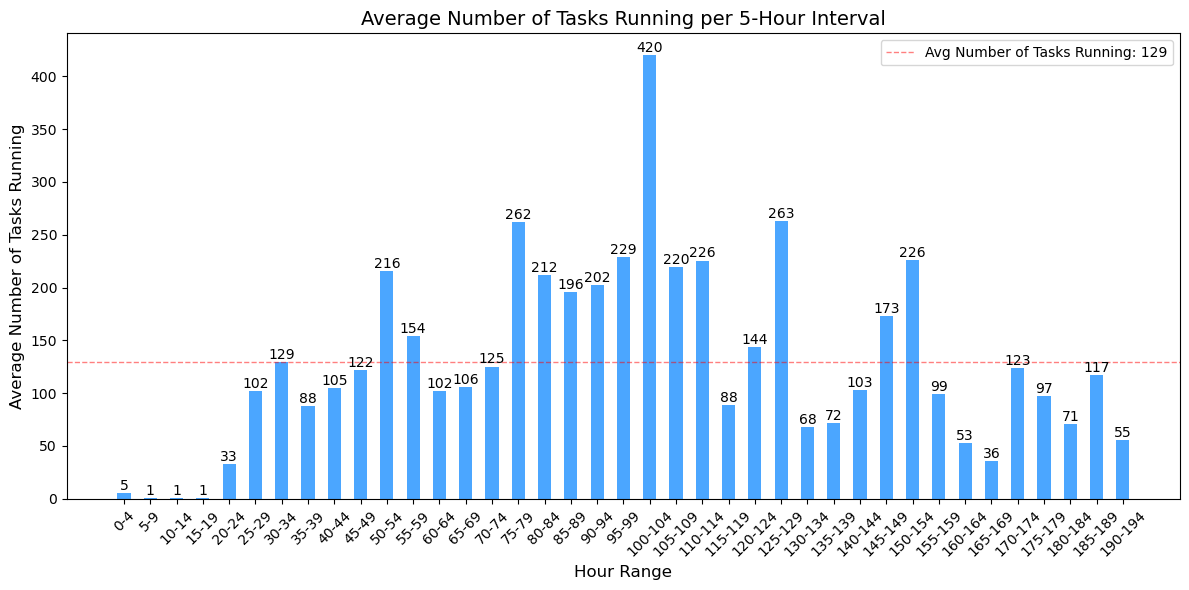

In [13]:
hourly_tasks = (running_tasks.assign(hour=lambda df: df.apply(lambda row: range(row['start_hour'], row['end_hour'] + 1), axis=1)).explode('hour'))
task_counts = (hourly_tasks.groupby(['hour'])['task_name'].nunique().reset_index(name='num_tasks'))
task_counts = task_counts.dropna(subset=['hour', 'num_tasks'])

plot_with_24h_means(data=task_counts, col_name='num_tasks', color='orange', ylabel='Number of Tasks Running', title='Avg Number of Tasks Running')
task_counts['interval'] = (task_counts['hour'] // 5) * 5
interval_avg = task_counts.groupby('interval')['num_tasks'].mean().reset_index()
overall_mean = interval_avg['num_tasks'].mean()

plt.figure(figsize=(12, 6))
bars = plt.bar([f"{int(x)}-{int(x)+4}" for x in interval_avg['interval']], interval_avg['num_tasks'], color='#1E90FF', alpha=0.8, width=0.5)
plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=1, label=f'Avg Number of Tasks Running: {round(overall_mean)}', alpha=0.5)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{round(bar.get_height())}', ha='center', va='bottom')

plt.title('Average Number of Tasks Running per 5-Hour Interval', fontsize=14)
plt.xlabel('Hour Range', fontsize=12)
plt.ylabel('Average Number of Tasks Running', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('alibaba_plots/Alibaba_num_tasks_bar')
plt.show()

# Analysis of batch_instance csv -

In [14]:
# Reading 50 million rows
batch_instance = pd.read_csv('batch_instance.csv', nrows=50000000, header=None,
                             names=['instance_name','task_name','job_name','task_type',
                                    'status','start_time_instance','end_time_instance','machine_id','seq_no',
                                    'total_seq_no','cpu_avg','cpu_max','mem_avg','mem_max'])

batch_instance = batch_instance[["instance_name", "task_name", "task_type", "start_time_instance", "end_time_instance", "machine_id", "cpu_avg", "cpu_max", "mem_avg", "mem_max"]]
batch_instance = batch_instance.dropna(subset=["cpu_avg"])
# 100 is 1 core
batch_instance['cpu_avg'] = batch_instance['cpu_avg'] / 100
batch_instance['cpu_max'] = batch_instance['cpu_max'] / 100
batch_instance.head()

,instance_name,task_name,task_type,start_time_instance,end_time_instance,machine_id,cpu_avg,cpu_max,mem_avg,mem_max
0,ins_74901673,task_LTg0MTUwNTA5Mjg4MDkwNjIzMA==,10,673795,673797,m_2637,0.13,0.16,0.02,0.02
1,ins_815802872,M1,1,158478,158520,m_3430,0.03,0.19,0.13,0.18
2,ins_564677701,M1,1,372602,372616,m_1910,0.87,1.16,0.04,0.05
3,ins_257566161,M1,1,372602,372615,m_2485,0.91,1.23,0.05,0.05
4,ins_688679908,M1,1,372602,372615,m_993,0.93,1.41,0.05,0.05


In [15]:
task_type_resource_util = batch_instance.groupby('task_type')[['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']].mean().dropna()
task_type_resource_util

,cpu_avg,cpu_max,mem_avg,mem_max
task_type,,,,
1,0.625219,1.246617,0.107658,0.138465
3,0.824470,6.045977,0.057821,0.075857
4,0.610376,0.762981,0.035789,0.043227
6,0.157893,0.353657,0.020149,0.020979
7,0.190000,1.445000,0.300000,0.390000
8,0.479874,1.343546,0.138819,0.198021
9,0.829633,3.190620,0.173793,0.204449
10,0.723130,0.880720,0.050669,0.055785
11,1.999600,4.079458,0.112568,0.140485


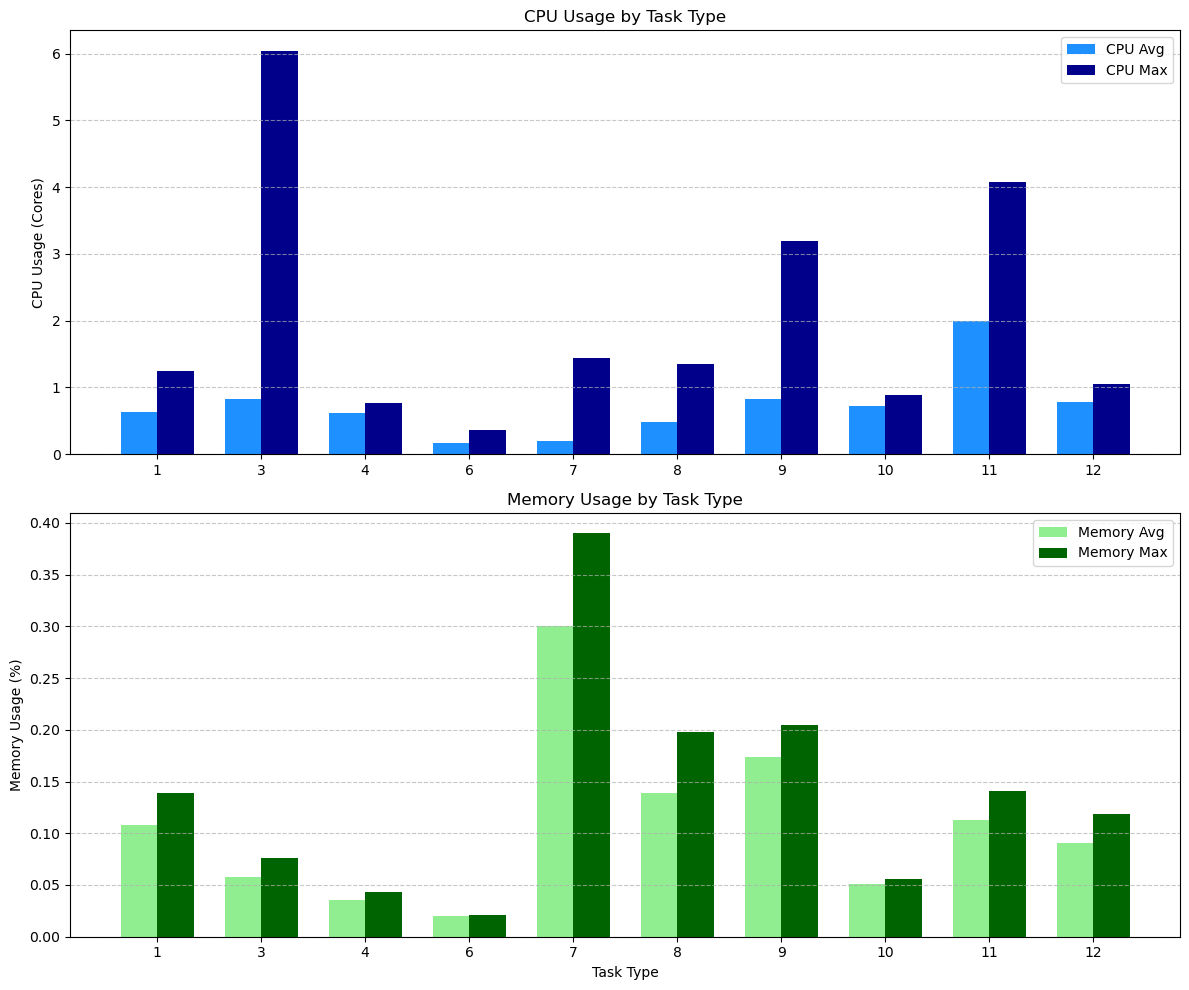

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
x = np.arange(len(task_type_resource_util.index))
width = 0.35

ax1.bar(x - width/2, task_type_resource_util['cpu_avg'], width, label='CPU Avg', color='dodgerblue')
ax1.bar(x + width/2, task_type_resource_util['cpu_max'], width, label='CPU Max', color='darkblue')
ax1.set_ylabel('CPU Usage (Cores)')
ax1.set_title('CPU Usage by Task Type')
ax1.set_xticks(x)
ax1.set_xticklabels(task_type_resource_util.index)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.bar(x - width/2, task_type_resource_util['mem_avg'], width, label='Memory Avg', color='lightgreen')
ax2.bar(x + width/2, task_type_resource_util['mem_max'], width, label='Memory Max', color='darkgreen')
ax2.set_xlabel('Task Type')
ax2.set_ylabel('Memory Usage (%)')
ax2.set_title('Memory Usage by Task Type')
ax2.set_xticks(x)
ax2.set_xticklabels(task_type_resource_util.index)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('alibaba_plots/alibaba_task_resource_usage.png')
plt.show()

## Predictive Analysis -

In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [32]:
data_to_predict = batch_instance[['task_type', 'start_time_instance', 'end_time_instance', 'machine_id', 'cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']]
data_to_predict = data_to_predict.dropna()
data_to_predict.head()

,task_type,start_time_instance,end_time_instance,machine_id,cpu_avg,cpu_max,mem_avg,mem_max
0,10,673795,673797,m_2637,0.13,0.16,0.02,0.02
1,1,158478,158520,m_3430,0.03,0.19,0.13,0.18
2,1,372602,372616,m_1910,0.87,1.16,0.04,0.05
3,1,372602,372615,m_2485,0.91,1.23,0.05,0.05
4,1,372602,372615,m_993,0.93,1.41,0.05,0.05


In [33]:
data_to_predict["total_time_running"] = data_to_predict['end_time_instance'] - data_to_predict['start_time_instance']
data_to_predict["vm_creation_hour_of_day"] = (data_to_predict["start_time_instance"] / 3600) % 24
training_data_X, testing_data_X, training_data_Y, testing_data_Y = train_test_split(data_to_predict[["vm_creation_hour_of_day", "total_time_running", "task_type"]], data_to_predict["cpu_avg"], test_size = 0.05)

In [36]:
xgboost_regressor_model = XGBRegressor(n_estimators = 1500)
xgboost_regressor_model.fit(training_data_X, training_data_Y)
avg_cpu_prediction_values = xgboost_regressor_model.predict(testing_data_X)
print(avg_cpu_prediction_values)
root_mean_squared_error(testing_data_Y * 100, avg_cpu_prediction_values * 100)

[0.44832546 0.6254716  0.26772404 ... 0.6964749  0.69161016 0.5859877 ]


23.3734438773299

In [ ]:
root_mean_squared_error(testing_data_Y * 100, avg_cpu_prediction_values * 100)

In [37]:
diff_in_prediction_vals_from_truth = (abs(avg_cpu_prediction_values - testing_data_Y)).to_list()
prediction_in_range_counter = 0
for curr_diff in diff_in_prediction_vals_from_truth:
    if curr_diff <= 0.1:
        prediction_in_range_counter = prediction_in_range_counter + 1
model_avg_cpu_pred_accuracy = prediction_in_range_counter * 100 / len(diff_in_prediction_vals_from_truth)
print("Model's Average CPU Utilization Precition accuracy is:", str(model_avg_cpu_pred_accuracy) + "%")

Model's Average CPU Utilization Precition accuracy is: 52.53613085850801%


In [ ]:
training_data_X, testing_data_X, training_data_Y, testing_data_Y = train_test_split(data_to_predict[["vm_creation_hour_of_day", "total_time_running", "task_type"]], data_to_predict["mem_avg"], test_size = 0.05)

In [39]:
xgboost_regressor_model = XGBRegressor(n_estimators = 1500)
xgboost_regressor_model.fit(training_data_X, training_data_Y)
avg_mem_prediction_values = xgboost_regressor_model.predict(testing_data_X)
print(avg_mem_prediction_values)

[0.10824015 0.03754018 0.05664064 ... 0.02165665 0.06909399 0.05594576]


In [42]:
root_mean_squared_error(testing_data_Y, avg_mem_prediction_values)

0.18460717351350522

In [43]:
diff_in_prediction_vals_from_truth = (abs(avg_mem_prediction_values - testing_data_Y)).to_list()
prediction_in_range_counter = 0
for curr_diff in diff_in_prediction_vals_from_truth:
    if curr_diff <= 0.1:
        prediction_in_range_counter = prediction_in_range_counter + 1
model_avg_mem_pred_accuracy = prediction_in_range_counter * 100 / len(diff_in_prediction_vals_from_truth)
print("Model's Average Memory Utilization Precition accuracy is:", str(model_avg_mem_pred_accuracy) + "%")

Model's Average Memory Utilization Precition accuracy is: 87.71807334804072%
